# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


Este notebook muestra la construcción de un modelo de machine learning de juguete, usando datos de viajes de los taxis amarillos de Nueva York para el año 2020, [proporcionados por la NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

La idea es encontrar aquellos viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

Para ello ajustaremos un modelo de classificación binaria RandomForest usando los datos de los viajes de enero de 2020. Probaremos el modelo resultante sobre los datos de los viajes de febrero de 2020. Compararemos el desempeño del modelo en ambos casos usando la métrica de [f1-score](https://en.wikipedia.org/wiki/F-score).

**Este notebook está construido para ser ejecutado en [Google Colab](https://colab.research.google.com/), al que podemos acceder de manera gratuita solo teniendo un usuario de Google (Gmail) y un navegador web. No es necesario instalar nada en el computador local.**

## Cargando las librerías necesarias

In [58]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Leemos los datos de enero 2020 (entrenamiento)

In [59]:
pip install fastparquet



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Reading data

In [60]:
taxi = pd.read_parquet(r"C:\Users\alvar\OneDrive\Escritorio\Magister UDD\5 semestre\Desarrollo de productos\tarea1\data\data_inmutable\yellow_tripdata_2020-01.parquet")


In [61]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,NaN
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,NaN
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,NaN
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,NaN
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,NaN


In [62]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

## Descripción del Dataset

El diccionario de los datos puede encontrarse [acá](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):

| Field Name      | Description |
| ----------- | ----------- |
| VendorID      | A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.       |
| tpep_pickup_datetime   | The date and time when the meter was engaged.        |
| tpep_dropoff_datetime   | The date and time when the meter was disengaged.        |
| Passenger_count   | The number of passengers in the vehicle. This is a driver-entered value.      |
| Trip_distance   | The elapsed trip distance in miles reported by the taximeter.      |
| PULocationID   | TLC Taxi Zone in which the taximeter was engaged.      |
| DOLocationID   | TLC Taxi Zone in which the taximeter was disengaged      |
| RateCodeID   | The final rate code in effect at the end of the trip. 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride     |
| Store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip, N= not a store and forward trip |
| Payment_type | A numeric code signifying how the passenger paid for the trip. 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip |
| Fare_amount | The time-and-distance fare calculated by the meter. |
| Extra | Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges. |
| MTA_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use. |
| Improvement_surcharge | \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| Tip_amount | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip. |
| Total_amount | The total amount charged to passengers. Does not include cash tips. |

## Definimos las características con las que realizaremos la clasificación.

Las construiremos a continuación en la etapa de pre-procesamiento de los datos.

In [63]:
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

In [64]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)


In [65]:
target_col = "high_tip"

taxi_train = preprocess(df=taxi, target_col=target_col)

In [66]:
print(f'Num rows: {len(taxi_train)}, Size: {taxi_train.memory_usage(deep=True).sum() / 1e9} GB')

Num rows: 6382762, Size: 0.357434804 GB


In [67]:
taxi_train_enero = taxi_train

In [116]:
taxi_train_enero.columns

Index(['tpep_dropoff_datetime', 'pickup_weekday', 'pickup_hour', 'work_hours',
       'pickup_minute', 'passenger_count', 'trip_distance', 'trip_time',
       'trip_speed', 'PULocationID', 'DOLocationID', 'RatecodeID', 'high_tip',
       'day_of_month'],
      dtype='object')

## Ajustamos el modelo con los datos de entrenamiento

Este proceso se puede demorar bastante (¡en mi caso fueron 30 minutos!), pero podemos realizar una prueba mas pequeña reduciendo la cantidad de ejemplos de entrenamiento. Por ejemplo podríamos agregar la siguiente celda:

`taxi_train = taxi_train.head(100000)`

In [68]:
taxi_train = taxi_train.head(100000)

In [69]:
%%time

rfc = RandomForestClassifier(n_estimators=100, max_depth=10)

rfc.fit(taxi_train[features], taxi_train[target_col])

CPU times: total: 8.39 s
Wall time: 11.6 s


RandomForestClassifier(max_depth=10)

## Calculamos la métrica f1-score en el conjunto de entrenamiento

In [70]:
%%time
# Compute F1

preds = rfc.predict_proba(taxi_train[features])

CPU times: total: 484 ms
Wall time: 908 ms


In [71]:
preds

array([[0.39281419, 0.60718581],
       [0.39693724, 0.60306276],
       [0.49418793, 0.50581207],
       ...,
       [0.44755348, 0.55244652],
       [0.40341012, 0.59658988],
       [0.44229028, 0.55770972]])

In [72]:
preds_labels = [p[1] for p in preds.round()]

In [73]:
preds_labels[0:10]

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [74]:
print(f'F1: {f1_score(taxi_train[target_col], preds_labels)}')

F1: 0.6575469098601815


## Exportamos el modelo a un archivo

In [75]:
import joblib

joblib.dump(rfc, "random_forest.joblib")

['random_forest.joblib']

El archivo aparecerá en el menú del lado izquierdo, como se muestra en la foto. Podemos guardarlo en nuestro equipo usando boton derecho -> Download. Será útil hacerlo porque lo seguiremos usando en el futuro.

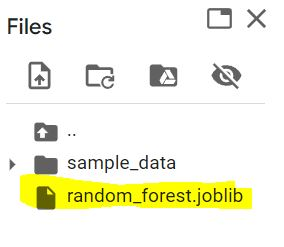

## Cargamos los datos de febrero 2020 (prueba)

In [76]:
taxi_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet')
taxi_test = preprocess(taxi_feb, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-02-01 00:30:32,5.0,0.0,0.0,17.0,1.0,2.60,777.0,0.003346,145.0,7.0,1.0,1
1,2020-02-01 01:05:36,5.0,0.0,0.0,32.0,1.0,4.80,1969.0,0.002438,45.0,61.0,1.0,1
2,2020-02-01 00:43:28,5.0,0.0,0.0,31.0,1.0,3.20,704.0,0.004545,186.0,140.0,1.0,0
3,2020-02-01 00:31:39,5.0,0.0,0.0,7.0,1.0,4.38,1444.0,0.003033,144.0,140.0,1.0,0
4,2020-02-01 01:01:29,5.0,0.0,0.0,51.0,1.0,2.28,586.0,0.003891,238.0,152.0,1.0,0


## Cargamos el modelo que guardamos y realizamos predicciones de prueba

In [77]:
loaded_rfc = joblib.load("random_forest.joblib")

In [78]:
%%time
# Compute F1
# This is (relatively) slow since we are copying data to the CPU to compute the metric.

preds_test = loaded_rfc.predict_proba(taxi_test[features])

CPU times: total: 30.6 s
Wall time: 46.1 s


In [79]:
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.3520149239723295


## Intentemos realizar la predicción de un solo viaje

Necesitaremos hacer algo así más adelante

In [80]:
taxi_test.head(1)[features].iloc[0].values

array([5.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7000000e+01,
       1.0000000e+00, 2.5999999e+00, 7.7700000e+02, 3.3462034e-03,
       1.4500000e+02, 7.0000000e+00, 1.0000000e+00], dtype=float32)

In [81]:
taxi_test.head(1)[target_col].iloc[0]

1

In [82]:
loaded_rfc.predict_proba(taxi_test.head(1)[features].iloc[0].values.reshape(1, -1))[0][1]

c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.5391593366214917

## Motivación: calculemos el desempeño para mayo de 2020

In [83]:
taxi_may= pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet')
taxi_test_mayo = preprocess(taxi_may, target_col=target_col)
taxi_test_mayo.head()

preds_test = loaded_rfc.predict_proba(taxi_test_mayo[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test_mayo[target_col], preds_test_labels)}')


F1: 0.5132813978588125


## 

### Saco mayo debido a la poca cantidad de registros comparado con Enero y Febrero

In [85]:
print("Estadísticas descriptivas para Enero:")
display(taxi_train_enero.describe())
print("Estadísticas descriptivas para Febrero:")
display(taxi_test.describe())


Estadísticas descriptivas para Enero:


,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
count,6382762,6.382762e+06,6.382762e+06,6.382762e+06,6.382762e+06,6.382762e+06,6.382762e+06,6.382762e+06,6.382762e+06,6.382762e+06,6.382762e+06,6.382762e+06,6.382762e+06
mean,2020-01-17 03:22:48.041708800,2.988001e+00,1.389552e+01,4.638609e-01,2.961376e+01,1.489884e+00,2.933347e+00,9.578384e+02,5.482594e+02,1.647439e+02,1.626620e+02,1.037413e+00,5.645852e-01
min,2008-12-31 23:32:32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-3.062000e+01,0.000000e+00,-1.318750e-02,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00
25%,2020-01-09 17:27:38,2.000000e+00,1.000000e+01,0.000000e+00,1.500000e+01,1.000000e+00,9.700000e-01,3.830000e+02,2.147595e-03,1.320000e+02,1.130000e+02,1.000000e+00,0.000000e+00
50%,2020-01-16 23:30:50,3.000000e+00,1.500000e+01,0.000000e+00,3.000000e+01,1.000000e+00,1.600000e+00,6.300000e+02,2.818991e-03,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+00
75%,2020-01-24 18:39:40,4.000000e+00,1.900000e+01,1.000000e+00,4.500000e+01,2.000000e+00,2.930000e+00,1.011000e+03,3.816667e-03,2.340000e+02,2.340000e+02,1.000000e+00,1.000000e+00
max,2021-01-02 01:25:01,6.000000e+00,2.300000e+01,1.000000e+00,5.900000e+01,9.000000e+00,2.102401e+05,8.639600e+04,2.840000e+08,2.650000e+02,2.650000e+02,9.900000e+01,1.000000e+00
std,NaN,1.850277e+00,5.881872e+00,4.986923e-01,1.733882e+01,1.173927e+00,8.330353e+01,3.776682e+03,2.147886e+05,6.553920e+01,6.990749e+01,8.126578e-01,4.958112e-01


Estadísticas descriptivas para Febrero:


,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
count,6276854,6.276854e+06,6.276854e+06,6.276854e+06,6.276854e+06,6.276854e+06,6.276854e+06,6.276854e+06,6.276854e+06,6.276854e+06,6.276854e+06,6.276854e+06,6.276854e+06
mean,2020-02-15 17:25:11.041622272,3.067811e+00,1.397536e+01,4.352728e-01,2.962943e+01,1.485299e+00,2.867933e+00,9.694325e+02,6.602369e+02,1.646137e+02,1.625398e+02,1.038619e+00,5.735360e-01
min,2008-12-31 22:55:19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00
25%,2020-02-08 05:13:40,1.000000e+00,1.000000e+01,0.000000e+00,1.500000e+01,1.000000e+00,9.600000e-01,3.940000e+02,2.060606e-03,1.250000e+02,1.130000e+02,1.000000e+00,0.000000e+00
50%,2020-02-15 07:34:06.500000,3.000000e+00,1.500000e+01,0.000000e+00,3.000000e+01,1.000000e+00,1.600000e+00,6.490000e+02,2.723577e-03,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+00
75%,2020-02-23 00:01:48,5.000000e+00,1.900000e+01,1.000000e+00,4.500000e+01,2.000000e+00,2.900000e+00,1.040000e+03,3.681592e-03,2.330000e+02,2.340000e+02,1.000000e+00,1.000000e+00
max,2020-07-11 12:59:24,6.000000e+00,2.300000e+01,1.000000e+00,5.900000e+01,9.000000e+00,5.705109e+04,8.639900e+04,2.150000e+08,2.650000e+02,2.650000e+02,9.900000e+01,1.000000e+00
std,NaN,1.904916e+00,5.925465e+00,4.957927e-01,1.733365e+01,1.161883e+00,4.034616e+01,3.683554e+03,2.332061e+05,6.553560e+01,6.976771e+01,7.808996e-01,4.945629e-01


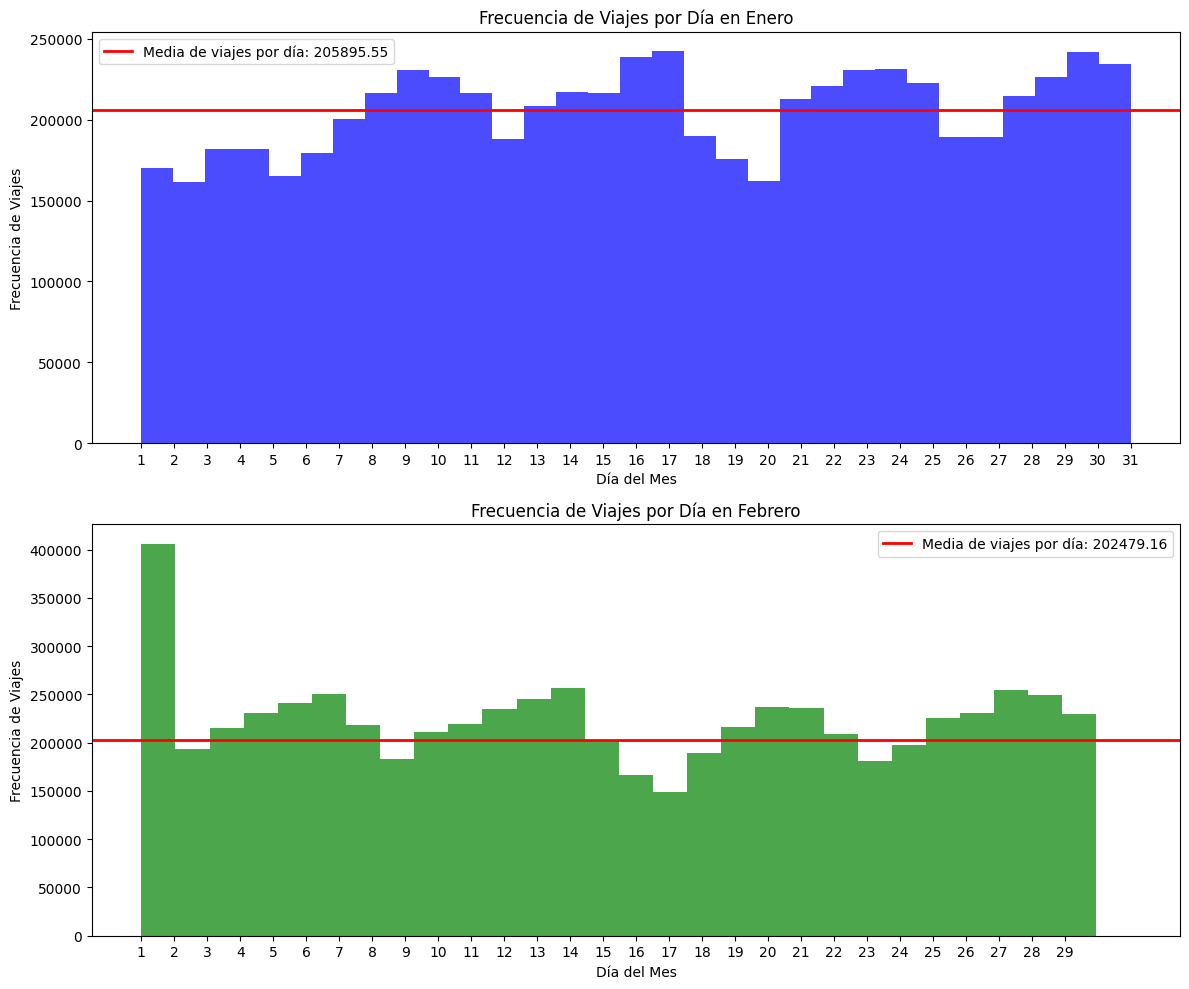

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que taxi_train_enero y taxi_test son tus DataFrames para enero y febrero

# Extraer el día del mes de la fecha de bajada
taxi_train_enero['day_of_month'] = taxi_train_enero['tpep_dropoff_datetime'].dt.day
taxi_test['day_of_month'] = taxi_test['tpep_dropoff_datetime'].dt.day

# Calcular las frecuencias diarias y la media de estas frecuencias para cada mes
daily_freq_enero = taxi_train_enero['day_of_month'].value_counts().sort_index()
mean_freq_enero = daily_freq_enero.mean()

daily_freq_febrero = taxi_test['day_of_month'].value_counts().sort_index()
mean_freq_febrero = daily_freq_febrero.mean()

# Crear la figura y los ejes para los histogramas
fig, ax = plt.subplots(2, 1, figsize=(12, 10))  # 2 filas, 1 columna

# Histograma para enero
ax[0].hist(taxi_train_enero['day_of_month'], bins=31, alpha=0.7, color='blue')
ax[0].axhline(mean_freq_enero, color='red', linewidth=2, label=f'Media de viajes por día: {mean_freq_enero:.2f}')
ax[0].set_title('Frecuencia de Viajes por Día en Enero')
ax[0].set_xlabel('Día del Mes')
ax[0].set_ylabel('Frecuencia de Viajes')
ax[0].set_xticks(range(1, 32))  # Asegurando que los ticks sean para cada día
ax[0].legend()

# Histograma para febrero
ax[1].hist(taxi_test['day_of_month'], bins=29, alpha=0.7, color='green')  # Febrero puede tener 28 o 29 días
ax[1].axhline(mean_freq_febrero, color='red', linewidth=2, label=f'Media de viajes por día: {mean_freq_febrero:.2f}')
ax[1].set_title('Frecuencia de Viajes por Día en Febrero')
ax[1].set_xlabel('Día del Mes')
ax[1].set_ylabel('Frecuencia de Viajes')
ax[1].set_xticks(range(1, 30))
ax[1].legend()

plt.tight_layout()
plt.show()


In [90]:
# Identificar los días que exceden la media y calcular la suma de las áreas para Enero
excess_enero = daily_freq_enero[daily_freq_enero > mean_freq_enero]
sum_excess_enero = (excess_enero - mean_freq_enero).sum()

# Identificar los días que exceden la media y calcular la suma de las áreas para Febrero
excess_febrero = daily_freq_febrero[daily_freq_febrero > mean_freq_febrero]
sum_excess_febrero = (excess_febrero - mean_freq_febrero).sum()

print(f"viajes sobre la frecuencia media de Enero: {sum_excess_enero}")
print(f"viajes sobre la frecuencia media de Febrero: {sum_excess_febrero}")


viajes sobre la frecuencia media de Enero: 342373.1290322578
viajes sobre la frecuencia media de Febrero: 571646.7741935486


en base a esto, podemos saber que en febrero se realizaron + viajes exedentes de la frecuencia diaria que en Enero, lo cual añade una capa de explicación al por que el modelo fue más preciso. En definitiva mi hipotesis es que el modelo se comporta mejor cuando hay + "hubs" sobre la frecuencia de viajes.

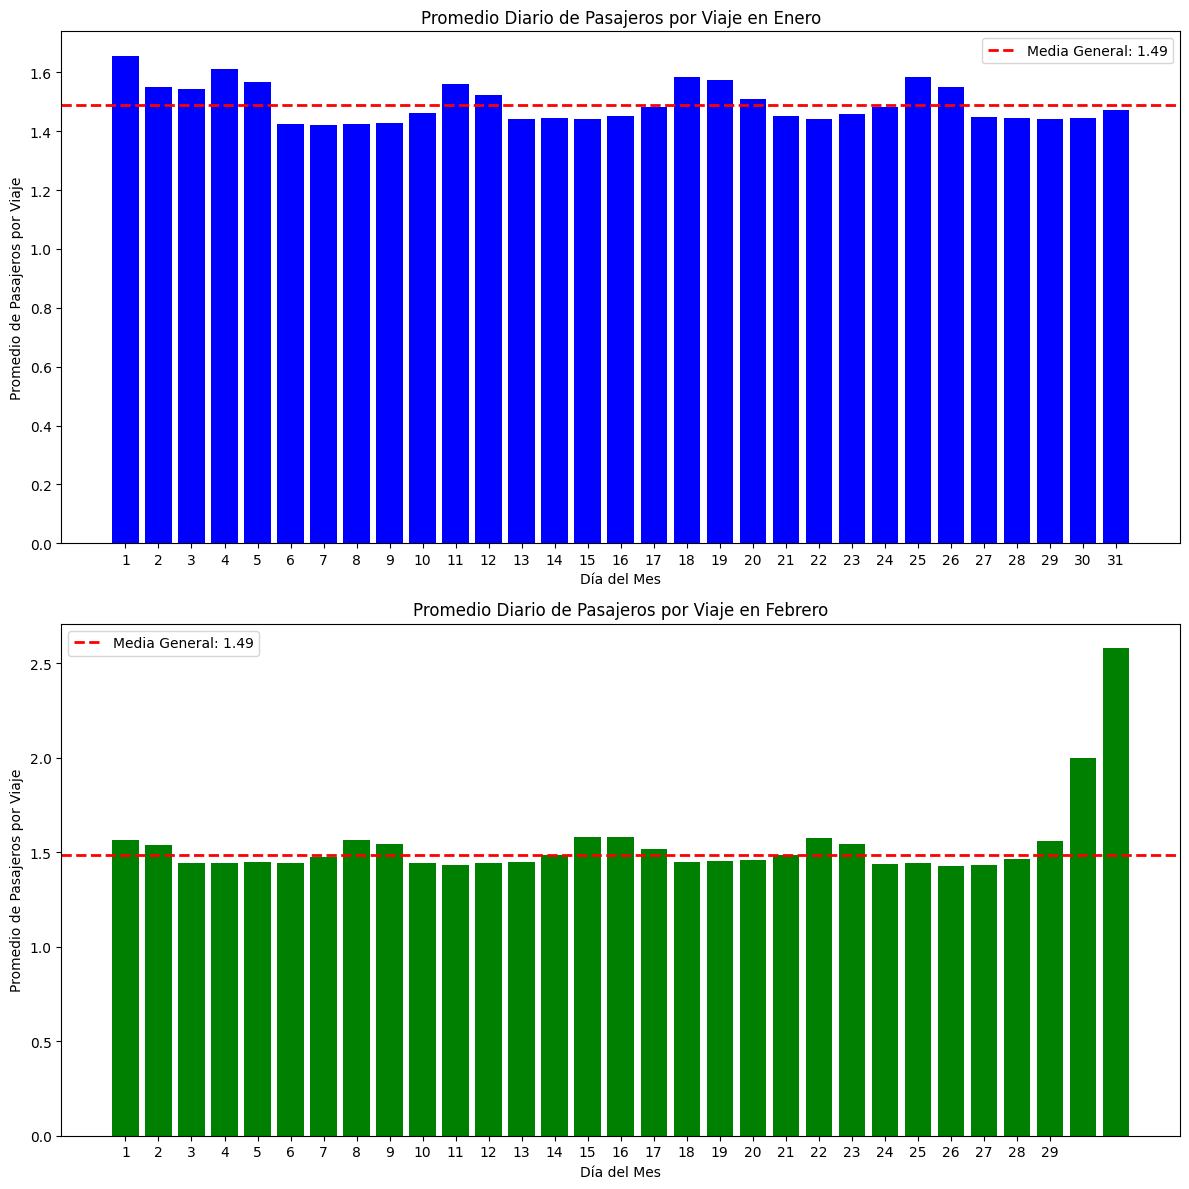

In [99]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir la columna 'tpep_dropoff_datetime' a datetime si no lo está
taxi_train_enero['tpep_dropoff_datetime'] = pd.to_datetime(taxi_train_enero['tpep_dropoff_datetime'])
taxi_test['tpep_dropoff_datetime'] = pd.to_datetime(taxi_test['tpep_dropoff_datetime'])

# Extraer el día del mes
taxi_train_enero['day_of_month'] = taxi_train_enero['tpep_dropoff_datetime'].dt.day
taxi_test['day_of_month'] = taxi_test['tpep_dropoff_datetime'].dt.day

# Calcular el promedio diario de pasajeros para cada mes
daily_passenger_avg_enero = taxi_train_enero.groupby('day_of_month')['passenger_count'].mean()
daily_passenger_avg_febrero = taxi_test.groupby('day_of_month')['passenger_count'].mean()

# Combinar los datos para calcular la media general de pasajeros por viaje para ambos meses
combined_data = pd.concat([taxi_train_enero['passenger_count'], taxi_test['passenger_count']])
overall_passenger_mean = combined_data.mean()

# Crear la figura y los ejes para los histogramas
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Histograma para enero
ax[0].bar(daily_passenger_avg_enero.index, daily_passenger_avg_enero, color='blue')
ax[0].axhline(overall_passenger_mean, color='red', linestyle='--', linewidth=2, label=f'Media General: {overall_passenger_mean:.2f}')
ax[0].set_title('Promedio Diario de Pasajeros por Viaje en Enero')
ax[0].set_xlabel('Día del Mes')
ax[0].set_ylabel('Promedio de Pasajeros por Viaje')
ax[0].set_xticks(range(1, 32))
ax[0].legend()

# Histograma para febrero
ax[1].bar(daily_passenger_avg_febrero.index, daily_passenger_avg_febrero, color='green')
ax[1].axhline(overall_passenger_mean, color='red', linestyle='--', linewidth=2, label=f'Media General: {overall_passenger_mean:.2f}')
ax[1].set_title('Promedio Diario de Pasajeros por Viaje en Febrero')
ax[1].set_xlabel('Día del Mes')
ax[1].set_ylabel('Promedio de Pasajeros por Viaje')
ax[1].set_xticks(range(1, 30))  # Asumiendo que febrero puede tener 28 o 29 días
ax[1].legend()

# Mostrar la figura
plt.tight_layout()
plt.show()


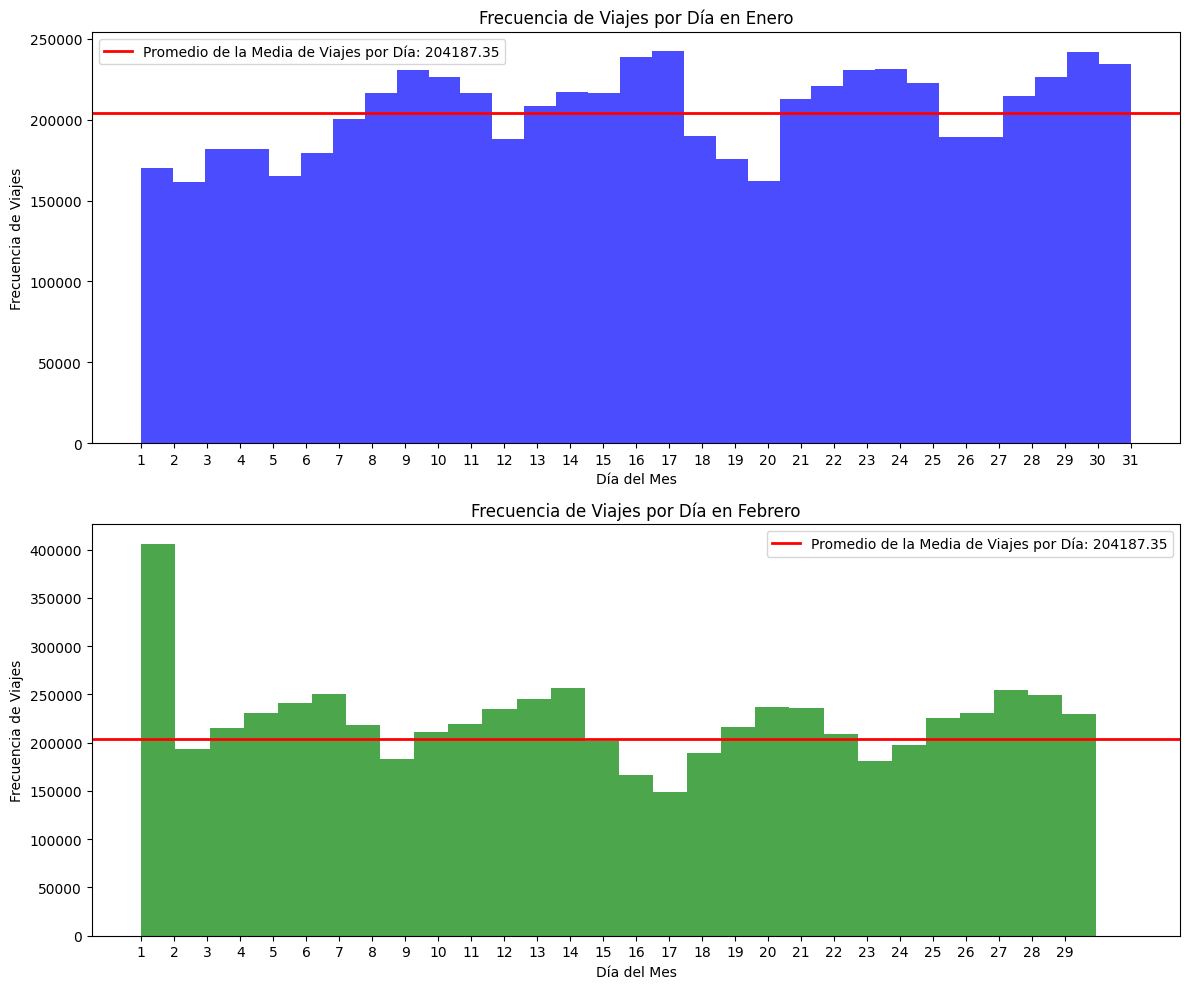

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que taxi_train_enero y taxi_test son tus DataFrames para enero y febrero

# Extraer el día del mes de la fecha de bajada
taxi_train_enero['day_of_month'] = taxi_train_enero['tpep_dropoff_datetime'].dt.day
taxi_test['day_of_month'] = taxi_test['tpep_dropoff_datetime'].dt.day

# Calcular las frecuencias diarias para cada mes
daily_freq_enero = taxi_train_enero['day_of_month'].value_counts().sort_index()
mean_freq_enero = daily_freq_enero.mean()

daily_freq_febrero = taxi_test['day_of_month'].value_counts().sort_index()
mean_freq_febrero = daily_freq_febrero.mean()

# Calcular el promedio de las medias mensuales
average_of_means = (mean_freq_enero + mean_freq_febrero) / 2

# Crear la figura y los ejes para los histogramas
fig, ax = plt.subplots(2, 1, figsize=(12, 10))  # 2 filas, 1 columna

# Histograma para enero
ax[0].hist(taxi_train_enero['day_of_month'], bins=31, alpha=0.7, color='blue')
ax[0].axhline(average_of_means, color='red', linewidth=2, label=f'Promedio de la Media de Viajes por Día: {average_of_means:.2f}')
ax[0].set_title('Frecuencia de Viajes por Día en Enero')
ax[0].set_xlabel('Día del Mes')
ax[0].set_ylabel('Frecuencia de Viajes')
ax[0].set_xticks(range(1, 32))
ax[0].legend()

# Histograma para febrero
ax[1].hist(taxi_test['day_of_month'], bins=29, alpha=0.7, color='green')
ax[1].axhline(average_of_means, color='red', linewidth=2, label=f'Promedio de la Media de Viajes por Día: {average_of_means:.2f}')
ax[1].set_title('Frecuencia de Viajes por Día en Febrero')
ax[1].set_xlabel('Día del Mes')
ax[1].set_ylabel('Frecuencia de Viajes')
ax[1].set_xticks(range(1, 30))
ax[1].legend()

plt.tight_layout()
plt.show()


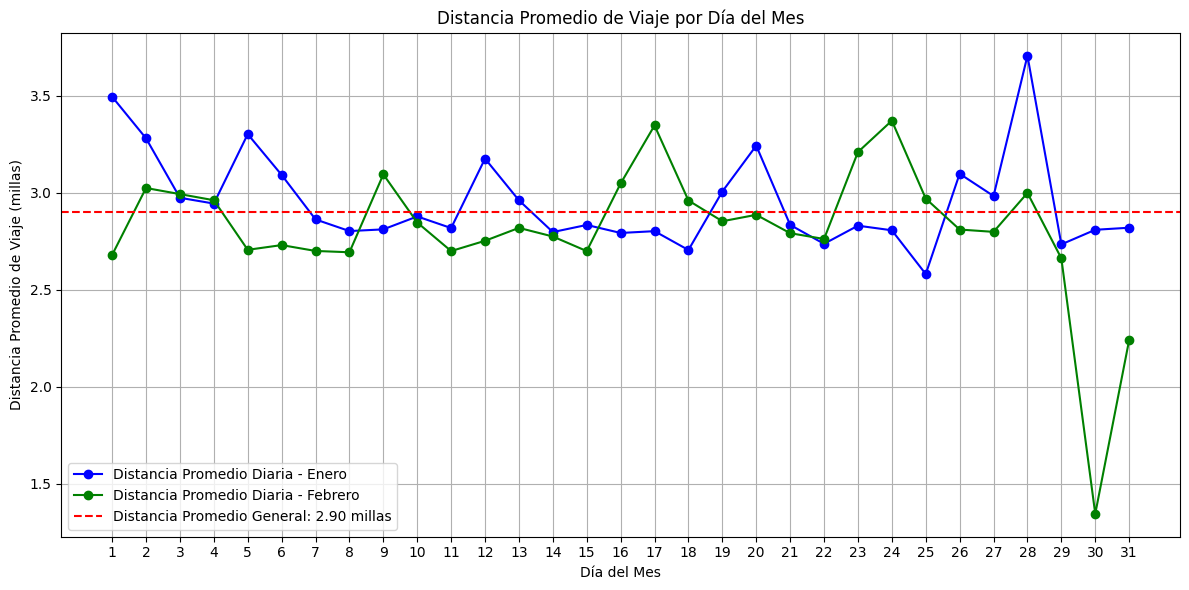

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

# Calcular la distancia promedio diaria para enero y febrero
daily_distance_avg_enero = taxi_train_enero.groupby('day_of_month')['trip_distance'].mean()
daily_distance_avg_febrero = taxi_test.groupby('day_of_month')['trip_distance'].mean()

# Concatenar ambos DataFrames para calcular la distancia promedio general
combined_df = pd.concat([taxi_train_enero, taxi_test])

# Calcular la distancia promedio general de ambos meses
overall_distance_avg = combined_df['trip_distance'].mean()

# Crear la figura para el gráfico de líneas
plt.figure(figsize=(12, 6))

# Graficar la distancia promedio diaria para enero
plt.plot(daily_distance_avg_enero.index, daily_distance_avg_enero, label='Distancia Promedio Diaria - Enero', color='blue', marker='o')

# Graficar la distancia promedio diaria para febrero
plt.plot(daily_distance_avg_febrero.index, daily_distance_avg_febrero, label='Distancia Promedio Diaria - Febrero', color='green', marker='o')

# Graficar la distancia promedio general de ambos meses
plt.axhline(overall_distance_avg, color='red', linestyle='--', label=f'Distancia Promedio General: {overall_distance_avg:.2f} millas')

# Configuración del gráfico
plt.title('Distancia Promedio de Viaje por Día del Mes')
plt.xlabel('Día del Mes')
plt.ylabel('Distancia Promedio de Viaje (millas)')
plt.xticks(range(1, 32))  # Asegurando que los ticks sean para cada día del mes
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [110]:
import pandas as pd

# Suponiendo que la distancia promedio general 'overall_distance_avg' es 2.9 millas
overall_distance_avg = 2.9

# Contar viajes en enero donde la distancia fue mayor a 2.9 millas
greater_than_avg_enero = taxi_train_enero[taxi_train_enero['trip_distance'] > overall_distance_avg]
count_greater_enero = greater_than_avg_enero['trip_distance'].count()

# Contar viajes en febrero donde la distancia fue mayor a 2.9 millas
greater_than_avg_febrero = taxi_test[taxi_test['trip_distance'] > overall_distance_avg]
count_greater_febrero = greater_than_avg_febrero['trip_distance'].count()

# Mostrar los resultados
print(f'Cantidad de viajes en enero con distancia mayor a 2.9 millas: {count_greater_enero}')
print(f'Cantidad de viajes en febrero con distancia mayor a 2.9 millas: {count_greater_febrero}')


Cantidad de viajes en enero con distancia mayor a 2.9 millas: 1608478
Cantidad de viajes en febrero con distancia mayor a 2.9 millas: 1556748


In [111]:
import pandas as pd

# Suponiendo que la distancia promedio general 'overall_distance_avg' es 2.9 millas
overall_distance_avg = 2.9

# Calcular la diferencia de distancia para viajes que excedieron el promedio en enero
greater_than_avg_enero = taxi_train_enero[taxi_train_enero['trip_distance'] > overall_distance_avg]
difference_enero = (greater_than_avg_enero['trip_distance'] - overall_distance_avg).sum()

# Calcular la diferencia de distancia para viajes que excedieron el promedio en febrero
greater_than_avg_febrero = taxi_test[taxi_test['trip_distance'] > overall_distance_avg]
difference_febrero = (greater_than_avg_febrero['trip_distance'] - overall_distance_avg).sum()

# Mostrar los resultados
print(f'Suma total de la diferencia de distancia en enero: {difference_enero} millas')
print(f'Suma total de la diferencia de distancia en febrero: {difference_febrero} millas')


Suma total de la diferencia de distancia en enero: 7649239.0 millas
Suma total de la diferencia de distancia en febrero: 7122307.5 millas


In [114]:
razon_diferencia = (difference_enero-difference_febrero)
print(razon_diferencia)

526931.5


In [115]:
porcentaje_diferencia =  razon_diferencia * 100/difference_febrero
print(porcentaje_diferencia)

7.398325612871952


En enero se recorrió un 7.39% más de distancia que en febrero. Lo cual mi hipotesis es que añade otra capa más de explicación a la diferencia entre efectividad del modelo

Para explicar de mejor forma la diferencia de acierto del modelo para ambos meses, se requiere mayor analisis para evaluar los comportamientos de más columnas. También me resulta interesante estudiar los metodos de pago y como influyen en la tarifa percibida, ya que de manera personal soy más "generoso" si debo pagar con debito/credito en comparación con el efectivo tangible y probablemente existan muchas personas así. De cualquier forma encuentro que esta tarea es un excelente ejercicio de ciencia de datos aplicada a data real, ya que desde ahora me resulta más facil aprovechar la data e imaginar situaciones para mejorar un negocio, en este caso de taxis, con el fin de mejorar el rendimiento economico de una empresa.